In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


# Data Preparation and Exploration

In [14]:
data=pd.read_csv(r"C:\Users\disha\Downloads\Timeseries\Timeseries\exchange_rate.csv", parse_dates=['date'], dayfirst=True)
data.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


# Plot Time Series

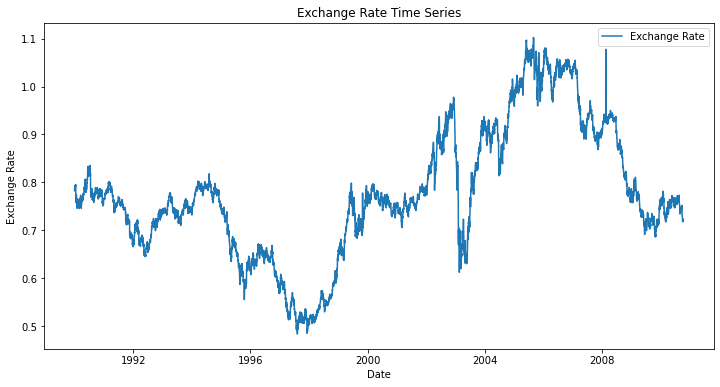

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Ex_rate'], label='Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.legend()
plt.show()

# Check for missing values

In [5]:
data.isnull().sum()

Ex_rate    0
dtype: int64

In [16]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


# ACF and PACF plots

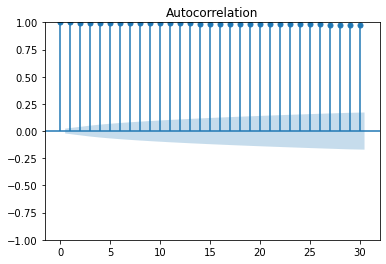

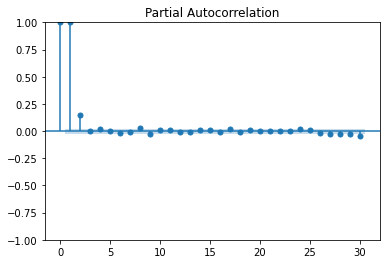

In [31]:
plot_acf(data['Ex_rate'], lags=30)
plt.show()

plot_pacf(data['Ex_rate'], lags=30)
plt.show()

# Model Fitting

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 2)   Log Likelihood               28055.068
Date:                Mon, 24 Jun 2024   AIC                         -56100.135
Time:                        23:16:57   BIC                         -56065.464
Sample:                             0   HQIC                        -56088.236
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1151      0.585     -0.197      0.844      -1.261       1.031
ar.L2          0.1132      0.088      1.293      0.196      -0.058       0.285
ma.L1         -0.0163      0.584     -0.028      0.9

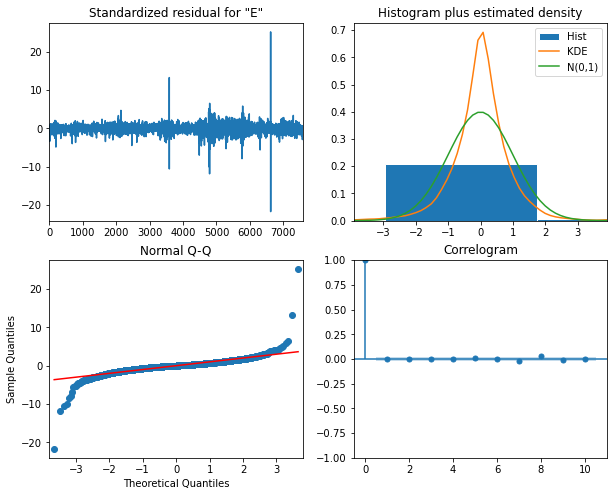

In [70]:
model_arima = ARIMA(data['Ex_rate'], order=(2, 1, 2))
arima_fit = model_arima.fit()

print(arima_fit.summary())
arima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

# Diagnostics: 

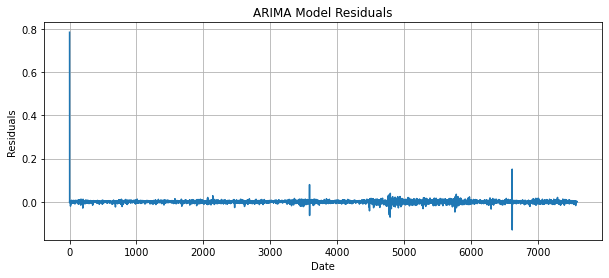

In [71]:
residuals = arima_result.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


# Forecasting

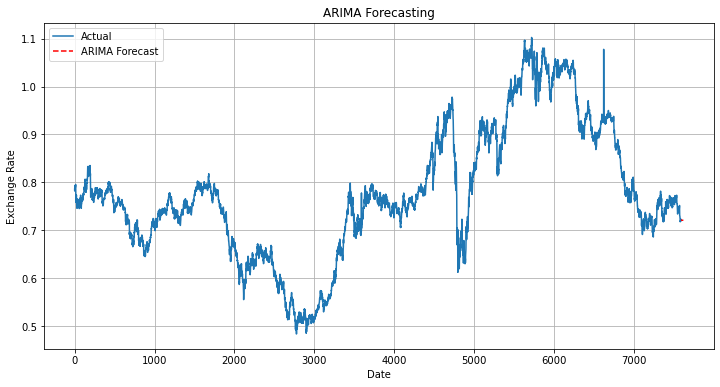

In [72]:
forecast_arima = arima_fit.forecast(steps=30) 

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual')
plt.plot(forecast_arima.index, forecast_arima, color='red', linestyle='--', label='ARIMA Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


# Model Selection

Holt-Winters models are effective in capturing trend and seasonality in time series data

# Grid Search for Holt-Winters

In [73]:
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [7, 14, 30]
}

grid = ParameterGrid(param_grid)
best_model = None
best_aic = np.inf

for params in grid:
    try:
        model = ExponentialSmoothing(data['Ex_rate'], trend=params['trend'], seasonal=params['seasonal'], seasonal_periods=params['seasonal_periods'])
        fit = model.fit()
        aic = fit.aic
        if aic < best_aic:
            best_aic = aic
            best_model = fit
            best_params = params
    except:
        continue

print("Best parameters:", best_params)
print("Best AIC:", best_aic)



Best parameters: {'seasonal': None, 'seasonal_periods': 7, 'trend': None}
Best AIC: -77644.98075014984


In [81]:
model_hw = ExponentialSmoothing(data['Ex_rate'], trend=best_params['trend'], seasonal=best_params['seasonal'], seasonal_periods=best_params['seasonal_periods'])
hw_fit = model_hw.fit()


# Forecast 

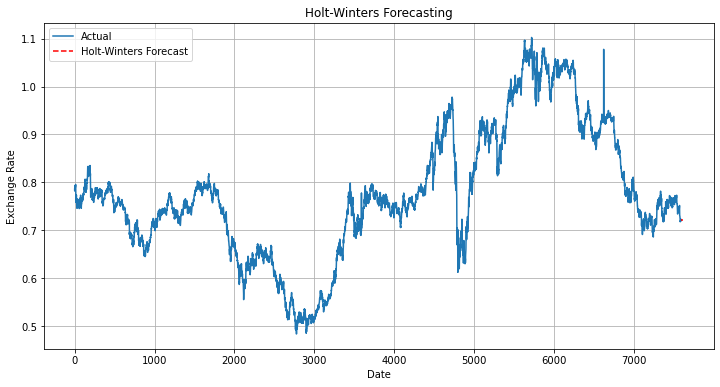

In [76]:
forecast_hw = hw_fit.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual')
plt.plot(forecast_hw.index, forecast_hw, color='red', linestyle='--', label='Holt-Winters Forecast')
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


# Compute error metrics for ARIMA

In [77]:
error_arima = actual_values - forecast_arima
mae_arima = mean_absolute_error(actual_values, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_arima))
mape_arima = np.mean(np.abs(error_arima / actual_values)) * 100

print("ARIMA Metrics:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.4f}%")


ARIMA Metrics:
MAE: 0.0127
RMSE: 0.0170
MAPE: 1.7113%


# Compute error metrics for Holt-Winters

In [78]:
error_hw = actual_values - forecast_hw
mae_hw = mean_absolute_error(actual_values, forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(actual_values, forecast_hw))
mape_hw = np.mean(np.abs(error_hw / actual_values)) * 100

print("\nHolt-Winters Metrics:")
print(f"MAE: {mae_hw:.4f}")
print(f"RMSE: {rmse_hw:.4f}")
print(f"MAPE: {mape_hw:.4f}%")


Holt-Winters Metrics:
MAE: 0.0127
RMSE: 0.0170
MAPE: 1.7097%


# Conclusion:

Based on the MAE, RMSE, and MAPE metrics, we can observe the following:

ARIMA model performed better in terms of MAPE.  
But both models, ARIMA and Holt-Winters, perform similarly well in forecasting the exchange rate based on the given dataset though small differences in MAPE 